In [ ]:
pip install tensorflow==2.13.0 numpy==1.24.0 pandas==1.5.0

In [1]:
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers
import requests
import pandas as pd
import seaborn as sns 
import numpy as np
import zipfile as zp
import re

In [2]:
data = pd.read_csv('model_features.csv')

In [3]:
data

,Unnamed: 0,nadac_per_unit,otc,year,package_size,units_reimbursed,number_of_prescriptions,total_amount_reimbursed,medicaid_amount_reimbursed,non_medicaid_amount_reimbursed,...,marketing_category_UNAPPROVED DRUG FOR USE IN DRUG SHORTAGE,marketing_category_UNAPPROVED DRUG OTHER,marketing_category_UNAPPROVED HOMEOPATHIC,EPCembed,CSembed,PEembed,MoAembed,EXTembed,ndc_desc_emb,days_in_market
0,0,29.01797,0,2024,60,11012.0,180,312410.53,290516.00,21894.53,...,0,0,0,[-3.30387093e-02 6.67294022e-03 -2.19613314e-...,[-4.34587672e-02 -1.21431332e-02 -2.81387810e-...,[ 2.63711698e-02 2.10511871e-02 -1.97666988e-...,NaN,NaN,[-6.43877834e-02 2.40811873e-02 2.58140061e-...,2438
1,1,2.08064,0,2022,75,1022.0,183,3242.93,3226.72,16.21,...,0,0,0,[-5.03016114e-02 3.01737450e-02 -3.95656079e-...,NaN,[ 2.91348379e-02 -8.86728168e-02 6.89277053e-...,NaN,NaN,[-7.97675028e-02 8.76037478e-02 -6.34495318e-...,2513
2,2,0.03721,0,2019,1,211969.0,6167,22643.53,21684.04,959.49,...,0,0,0,NaN,NaN,NaN,NaN,NaN,[-4.26063314e-02 8.58338103e-02 -9.33608338e-...,2153
3,3,0.03721,0,2019,5,2393477.0,61521,285542.60,278197.21,7345.39,...,0,0,0,NaN,NaN,NaN,NaN,NaN,[-4.26063314e-02 8.58338103e-02 -9.33608338e-...,2153
4,4,0.57622,0,2019,1,2589373.0,36643,1797460.34,1747856.31,49604.03,...,0,0,0,[-9.91146825e-03 5.58032654e-03 -2.00001523e-...,[ 1.39763737e-02 2.25846004e-02 -6.93783239e-...,[-1.79691091e-02 1.01037268e-02 -2.70781051e-...,[-7.78129324e-02 4.16403189e-02 -1.07955232e-...,NaN,[ 3.50452214e-02 1.59691423e-02 -5.32589108e-...,4965
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20006,20006,38.50800,0,2024,10,17.0,17,335.72,335.72,0.00,...,0,0,0,[-5.81455044e-02 -6.10000156e-02 -5.17241918e-...,NaN,NaN,[-9.77902487e-02 -3.28938439e-02 -1.08143296e-...,NaN,[ 5.99474348e-02 6.51338175e-02 -6.38899133e-...,279
20007,20007,2.30140,0,2022,1,2402.0,36,4476.00,4475.00,1.00,...,0,0,0,[-5.26543744e-02 3.59036885e-02 -2.97262836e-...,[-5.30931987e-02 2.05363072e-02 -4.40637209e-...,NaN,NaN,NaN,[ 7.38809258e-02 1.04536125e-02 -6.61890134e-...,1067
20008,20008,2.98385,0,2022,1,585.0,11,1158.57,1158.57,0.00,...,0,0,0,[-5.26543744e-02 3.59036885e-02 -2.97262836e-...,[-5.30931987e-02 2.05363072e-02 -4.40637209e-...,NaN,NaN,NaN,[ 5.51701784e-02 1.76252592e-02 -6.06536753e-...,1067
20009,20009,3.52974,0,2022,1,3350.0,56,7713.98,7484.28,229.70,...,0,0,0,[-5.26543744e-02 3.59036885e-02 -2.97262836e-...,[-5.30931987e-02 2.05363072e-02 -4.40637209e-...,NaN,NaN,NaN,[ 4.29866724e-02 2.91193780e-02 -9.34192836e-...,1067


In [4]:
data.drop(columns=['STARTMARKETINGDATE'], inplace=True)

In [5]:
replacement = np.zeros(384)

def replace(row):
    # Check if the value is NaN or missing
    if pd.isna(row):  # Use pandas' isna method
        return replacement
    else:
        return row

data['EPCembed'] = data['EPCembed'].apply(replace)
data['PEembed'] = data['PEembed'].apply(replace)
data['CSembed'] = data['CSembed'].apply(replace)
data['MoAembed'] = data['MoAembed'].apply(replace)
data['EXTembed'] = data['EXTembed'].apply(replace)
data['SUBSTANCENAME'] = data['SUBSTANCENAME'].apply(replace)

In [6]:
data['EPCembed']

0        [-3.30387093e-02  6.67294022e-03 -2.19613314e-...
1        [-5.03016114e-02  3.01737450e-02 -3.95656079e-...
2        [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
3        [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
4        [-9.91146825e-03  5.58032654e-03 -2.00001523e-...
                               ...                        
20006    [-5.81455044e-02 -6.10000156e-02 -5.17241918e-...
20007    [-5.26543744e-02  3.59036885e-02 -2.97262836e-...
20008    [-5.26543744e-02  3.59036885e-02 -2.97262836e-...
20009    [-5.26543744e-02  3.59036885e-02 -2.97262836e-...
20010    [-5.26543744e-02  3.59036885e-02 -2.97262836e-...
Name: EPCembed, Length: 20011, dtype: object

In [7]:
scalar = ['otc', 'year', 'package_size', 'units_reimbursed',
       'number_of_prescriptions', 'total_amount_reimbursed',
       'medicaid_amount_reimbursed', 'non_medicaid_amount_reimbursed',
          'month', 'day', 'classification_for_rate_B',
       'classification_for_rate_B-ANDA', 'classification_for_rate_B-BIO',
       'classification_for_rate_G', 'pricing_EA', 'pricing_GM', 'pricing_ML',
       'marketing_category_ANDA', 'marketing_category_BLA',
       'marketing_category_NDA', 'marketing_category_NDA AUTHORIZED GENERIC',
       'marketing_category_OTC MONOGRAPH DRUG',
       'marketing_category_OTC MONOGRAPH FINAL',
       'marketing_category_OTC MONOGRAPH NOT FINAL',
       'marketing_category_UNAPPROVED DRUG FOR USE IN DRUG SHORTAGE',
       'marketing_category_UNAPPROVED DRUG OTHER',
       'marketing_category_UNAPPROVED HOMEOPATHIC', 'days_in_market']
embeddings = ['EPCembed', 'CSembed', 'PEembed', 'MoAembed', 'EXTembed', 'ndc_desc_emb', 'SUBSTANCENAME']
target = ['nadac_per_unit']

In [8]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scalar_vals = scaler.fit_transform(data[scalar])

In [9]:
target_arr = np.asarray(data[target].values)

In [10]:
target_arr

array([[29.01797],
       [ 2.08064],
       [ 0.03721],
       ...,
       [ 2.98385],
       [ 3.52974],
       [ 2.03394]])

In [11]:
for column in embeddings:
    dtype = data[column].dtype
    total_values = len(data[column])
    none_count = data[column].isna().sum()  # Count of None/NaN values
    actual_count = total_values - none_count  # Count of non-None/NaN values
    
    print(f"Column: {column}")
    print(f"  Data Type: {dtype}")
    print(f"  Non-None/NaN Values: {actual_count}")
    print(f"  None/NaN Values: {none_count}")
    print()

Column: EPCembed
  Data Type: object
  Non-None/NaN Values: 20011
  None/NaN Values: 0

Column: CSembed
  Data Type: object
  Non-None/NaN Values: 20011
  None/NaN Values: 0

Column: PEembed
  Data Type: object
  Non-None/NaN Values: 20011
  None/NaN Values: 0

Column: MoAembed
  Data Type: object
  Non-None/NaN Values: 20011
  None/NaN Values: 0

Column: EXTembed
  Data Type: object
  Non-None/NaN Values: 20011
  None/NaN Values: 0

Column: ndc_desc_emb
  Data Type: object
  Non-None/NaN Values: 20011
  None/NaN Values: 0

Column: SUBSTANCENAME
  Data Type: object
  Non-None/NaN Values: 20011
  None/NaN Values: 0



In [12]:
def convert_str_to_array(embedding_str):
    if isinstance(embedding_str, str):
        # Remove brackets and split the string by spaces
        values = embedding_str.strip('[]').split()
        # Convert the list of strings to a NumPy array of floats
        return np.array(values, dtype=float)
    else:
        return embedding_str
    
data['EPCembed'] = data['EPCembed'].apply(convert_str_to_array)
data['CSembed'] = data['CSembed'].apply(convert_str_to_array)
data['MoAembed'] = data['MoAembed'].apply(convert_str_to_array)
data['EXTembed'] = data['EXTembed'].apply(convert_str_to_array)
data['PEembed'] = data['PEembed'].apply(convert_str_to_array)
data['ndc_desc_emb'] = data['ndc_desc_emb'].apply(convert_str_to_array)
data['SUBSTANCENAME'] = data['SUBSTANCENAME'].apply(convert_str_to_array)

In [13]:
data['EPCembed']

0        [-0.0330387093, 0.00667294022, -0.0219613314, ...
1        [-0.0503016114, 0.030173745, -0.0395656079, 0....
2        [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
3        [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
4        [-0.00991146825, 0.00558032654, -0.0200001523,...
                               ...                        
20006    [-0.0581455044, -0.0610000156, -0.0517241918, ...
20007    [-0.0526543744, 0.0359036885, -0.0297262836, 0...
20008    [-0.0526543744, 0.0359036885, -0.0297262836, 0...
20009    [-0.0526543744, 0.0359036885, -0.0297262836, 0...
20010    [-0.0526543744, 0.0359036885, -0.0297262836, 0...
Name: EPCembed, Length: 20011, dtype: object

In [14]:
embedding_data = []
for col in embeddings:
    stacked = np.stack(data[col].values) 
    embedding_data.append(stacked)

In [15]:
embedding_data

[array([[-0.03303871,  0.00667294, -0.02196133, ...,  0.01406434,
          0.0429313 , -0.01748809],
        [-0.05030161,  0.03017374, -0.03956561, ..., -0.03180484,
          0.0394293 ,  0.0319773 ],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        ...,
        [-0.05265437,  0.03590369, -0.02972628, ..., -0.00099967,
          0.11913742,  0.04568711],
        [-0.05265437,  0.03590369, -0.02972628, ..., -0.00099967,
          0.11913742,  0.04568711],
        [-0.05265437,  0.03590369, -0.02972628, ..., -0.00099967,
          0.11913742,  0.04568711]]),
 array([[-0.04345877, -0.01214313, -0.02813878, ..., -0.02194291,
          0.10928751,  0.04152464],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        ...,
        [-0.0530932 ,  0.02053631, -0.04406372, ...,  

In [16]:
input_data = [scalar_vals] + embedding_data

In [17]:
input_data

[array([[0.        , 1.        , 0.60606061, ..., 0.        , 0.        ,
         0.05238095],
        [0.        , 0.6       , 0.75757576, ..., 0.        , 0.        ,
         0.05402677],
        [0.        , 0.        , 0.01010101, ..., 0.        , 0.        ,
         0.04612684],
        ...,
        [0.        , 0.6       , 0.01010101, ..., 0.        , 0.        ,
         0.02229537],
        [0.        , 0.6       , 0.01010101, ..., 0.        , 0.        ,
         0.02229537],
        [0.        , 0.6       , 0.01010101, ..., 0.        , 0.        ,
         0.02152732]]),
 array([[-0.03303871,  0.00667294, -0.02196133, ...,  0.01406434,
          0.0429313 , -0.01748809],
        [-0.05030161,  0.03017374, -0.03956561, ..., -0.03180484,
          0.0394293 ,  0.0319773 ],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        ...,
        [-0.05265437,  0.03590369, -0.02972628, ..., -0.00099967,
          0.11913742,  0

In [18]:
scalar_vals = np.array(scalar_vals)

# Ensure all embeddings are NumPy arrays
embedding_data = [np.array(embedding) for embedding in embedding_data]

# Ensure target is a NumPy array and has the correct shape
target_arr = np.array(target_arr).reshape(-1)

### Clearly overfitting on Training Data, New Model Below with Regularization and Dropout

In [19]:
from tensorflow.keras.optimizers import Adam

num_scalar = len(scalar)
num_embedding = len(embeddings)
embedding_dim = 384

scalar_input = layers.Input(shape=(num_scalar,), name='scalar_input')
scalar_dense = layers.Dense(16, activation='relu', kernel_regularizer=regularizers.l2(0.01))(scalar_input)
scalar_dense = layers.Dropout(0.2)(scalar_dense)  # Dropout after processing scalar inputs

embedding_inputs = []
embedding_denses = []
for i in range(num_embedding):
    embedding_input = layers.Input(shape=(embedding_dim,), name=f'embedding_input_{i}')
    embedding_dense = layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.01))(embedding_input)
    embedding_dense = layers.Dropout(0.2)(embedding_dense)  # Dropout after processing each embedding
    embedding_inputs.append(embedding_input)
    embedding_denses.append(embedding_dense)

combined = layers.Concatenate()([scalar_dense] + embedding_denses)
x = layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.01))(combined)
x = layers.Dropout(0.3)(x)  # Dropout after the combined Dense layer
x = layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.01))(x)
x = layers.Dropout(0.2)(x)  # Additional Dropout for regularization

output = layers.Dense(1, activation='linear', name='output')(x)

model = models.Model(inputs=[scalar_input] + embedding_inputs, outputs=output)

model.compile(optimizer=Adam(learning_rate=0.0001), loss='huber', metrics=['mae'])

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 scalar_input (InputLayer)   [(None, 28)]                 0         []                            
                                                                                                  
 embedding_input_0 (InputLa  [(None, 384)]                0         []                            
 yer)                                                                                             
                                                                                                  
 embedding_input_1 (InputLa  [(None, 384)]                0         []                            
 yer)                                                                                             
                                                                                              

In [20]:
target_scaler = MinMaxScaler()
target_normalized = target_scaler.fit_transform(target_arr.reshape(-1, 1))

In [21]:
history = model.fit(
    [scalar_vals] + embedding_data,  # Combine scalar and embedding inputs
    target_normalized,
    validation_split=0.2,
    epochs=10,
    batch_size=32
)

Epoch 1/10
501/501 [==============================] - 1s 2ms/step - loss: 5.9700 - mae: 0.0211 - val_loss: 2.7970 - val_mae: 0.0031
Epoch 2/10
501/501 [==============================] - 1s 2ms/step - loss: 1.4780 - mae: 0.0027 - val_loss: 0.6371 - val_mae: 8.5960e-04
Epoch 3/10
501/501 [==============================] - 1s 1ms/step - loss: 0.3291 - mae: 0.0015 - val_loss: 0.1445 - val_mae: 0.0019
Epoch 4/10
501/501 [==============================] - 1s 1ms/step - loss: 0.0826 - mae: 0.0016 - val_loss: 0.0449 - val_mae: 8.1197e-04
Epoch 5/10
501/501 [==============================] - 1s 2ms/step - loss: 0.0301 - mae: 0.0016 - val_loss: 0.0195 - val_mae: 6.3715e-04
Epoch 6/10
501/501 [==============================] - 1s 1ms/step - loss: 0.0139 - mae: 0.0015 - val_loss: 0.0094 - val_mae: 8.8203e-04
Epoch 7/10
501/501 [==============================] - 1s 1ms/step - loss: 0.0067 - mae: 0.0015 - val_loss: 0.0044 - val_mae: 8.0581e-04
Epoch 8/10
501/501 [==============================] - 1s

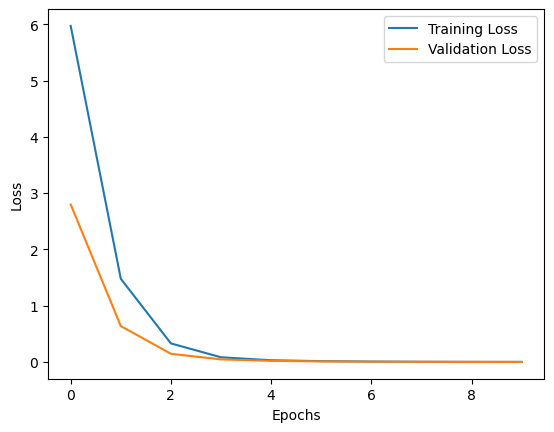

In [22]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [23]:
predictions_normalized = model.predict([scalar_vals] + embedding_data)
predictions = target_scaler.inverse_transform(predictions_normalized)

626/626 [==============================] - 0s 478us/step


In [24]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Calculate MAE and RMSE on the original scale
mae = mean_absolute_error(target_arr, predictions)
rmse = mean_squared_error(target_arr, predictions, squared=False)

print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")

MAE: 25.73
RMSE: 316.84


In [25]:
print(predictions_normalized)

[[0.00061492]
 [0.00061492]
 [0.00061492]
 ...
 [0.00061492]
 [0.00061492]
 [0.00061492]]


In [26]:
print(target_normalized)

[[1.34873198e-03]
 [9.66434820e-05]
 [1.66171495e-06]
 ...
 [1.38626071e-04]
 [1.63999877e-04]
 [9.44727943e-05]]
